In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score ,KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error , r2_score,make_scorer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load and Preprocess Training Data 

df = pd.read_csv('sales.csv')
print("Dataset loaded successfully. First 5 rows:")
print(df.head())
df.describe()

Dataset loaded successfully. First 5 rows:
   Unnamed: 0  store_ID  day_of_week        date  nb_customers_on_day  open  \
0      425390       366            4  2013-04-18                  517     1   
1      291687       394            6  2015-04-11                  694     1   
2      411278       807            4  2013-08-29                  970     1   
3      664714       802            2  2013-05-28                  473     1   
4      540835       726            4  2013-10-10                 1068     1   

   promotion state_holiday  school_holiday  sales  
0          0             0               0   4422  
1          0             0               0   8297  
2          1             0               0   9729  
3          1             0               0   6513  
4          1             0               0  10882  


,Unnamed: 0,store_ID,day_of_week,nb_customers_on_day,open,promotion,school_holiday,sales
count,640840.000000,640840.000000,640840.000000,640840.000000,640840.000000,640840.000000,640840.000000,640840.000000
mean,355990.675084,558.211348,4.000189,633.398577,0.830185,0.381718,0.178472,5777.469011
std,205536.290268,321.878521,1.996478,464.094416,0.375470,0.485808,0.382910,3851.338083
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,178075.750000,280.000000,2.000000,405.000000,1.000000,0.000000,0.000000,3731.000000
50%,355948.500000,558.000000,4.000000,609.000000,1.000000,0.000000,0.000000,5746.000000
75%,533959.250000,837.000000,6.000000,838.000000,1.000000,1.000000,0.000000,7860.000000
max,712044.000000,1115.000000,7.000000,5458.000000,1.000000,1.000000,1.000000,41551.000000


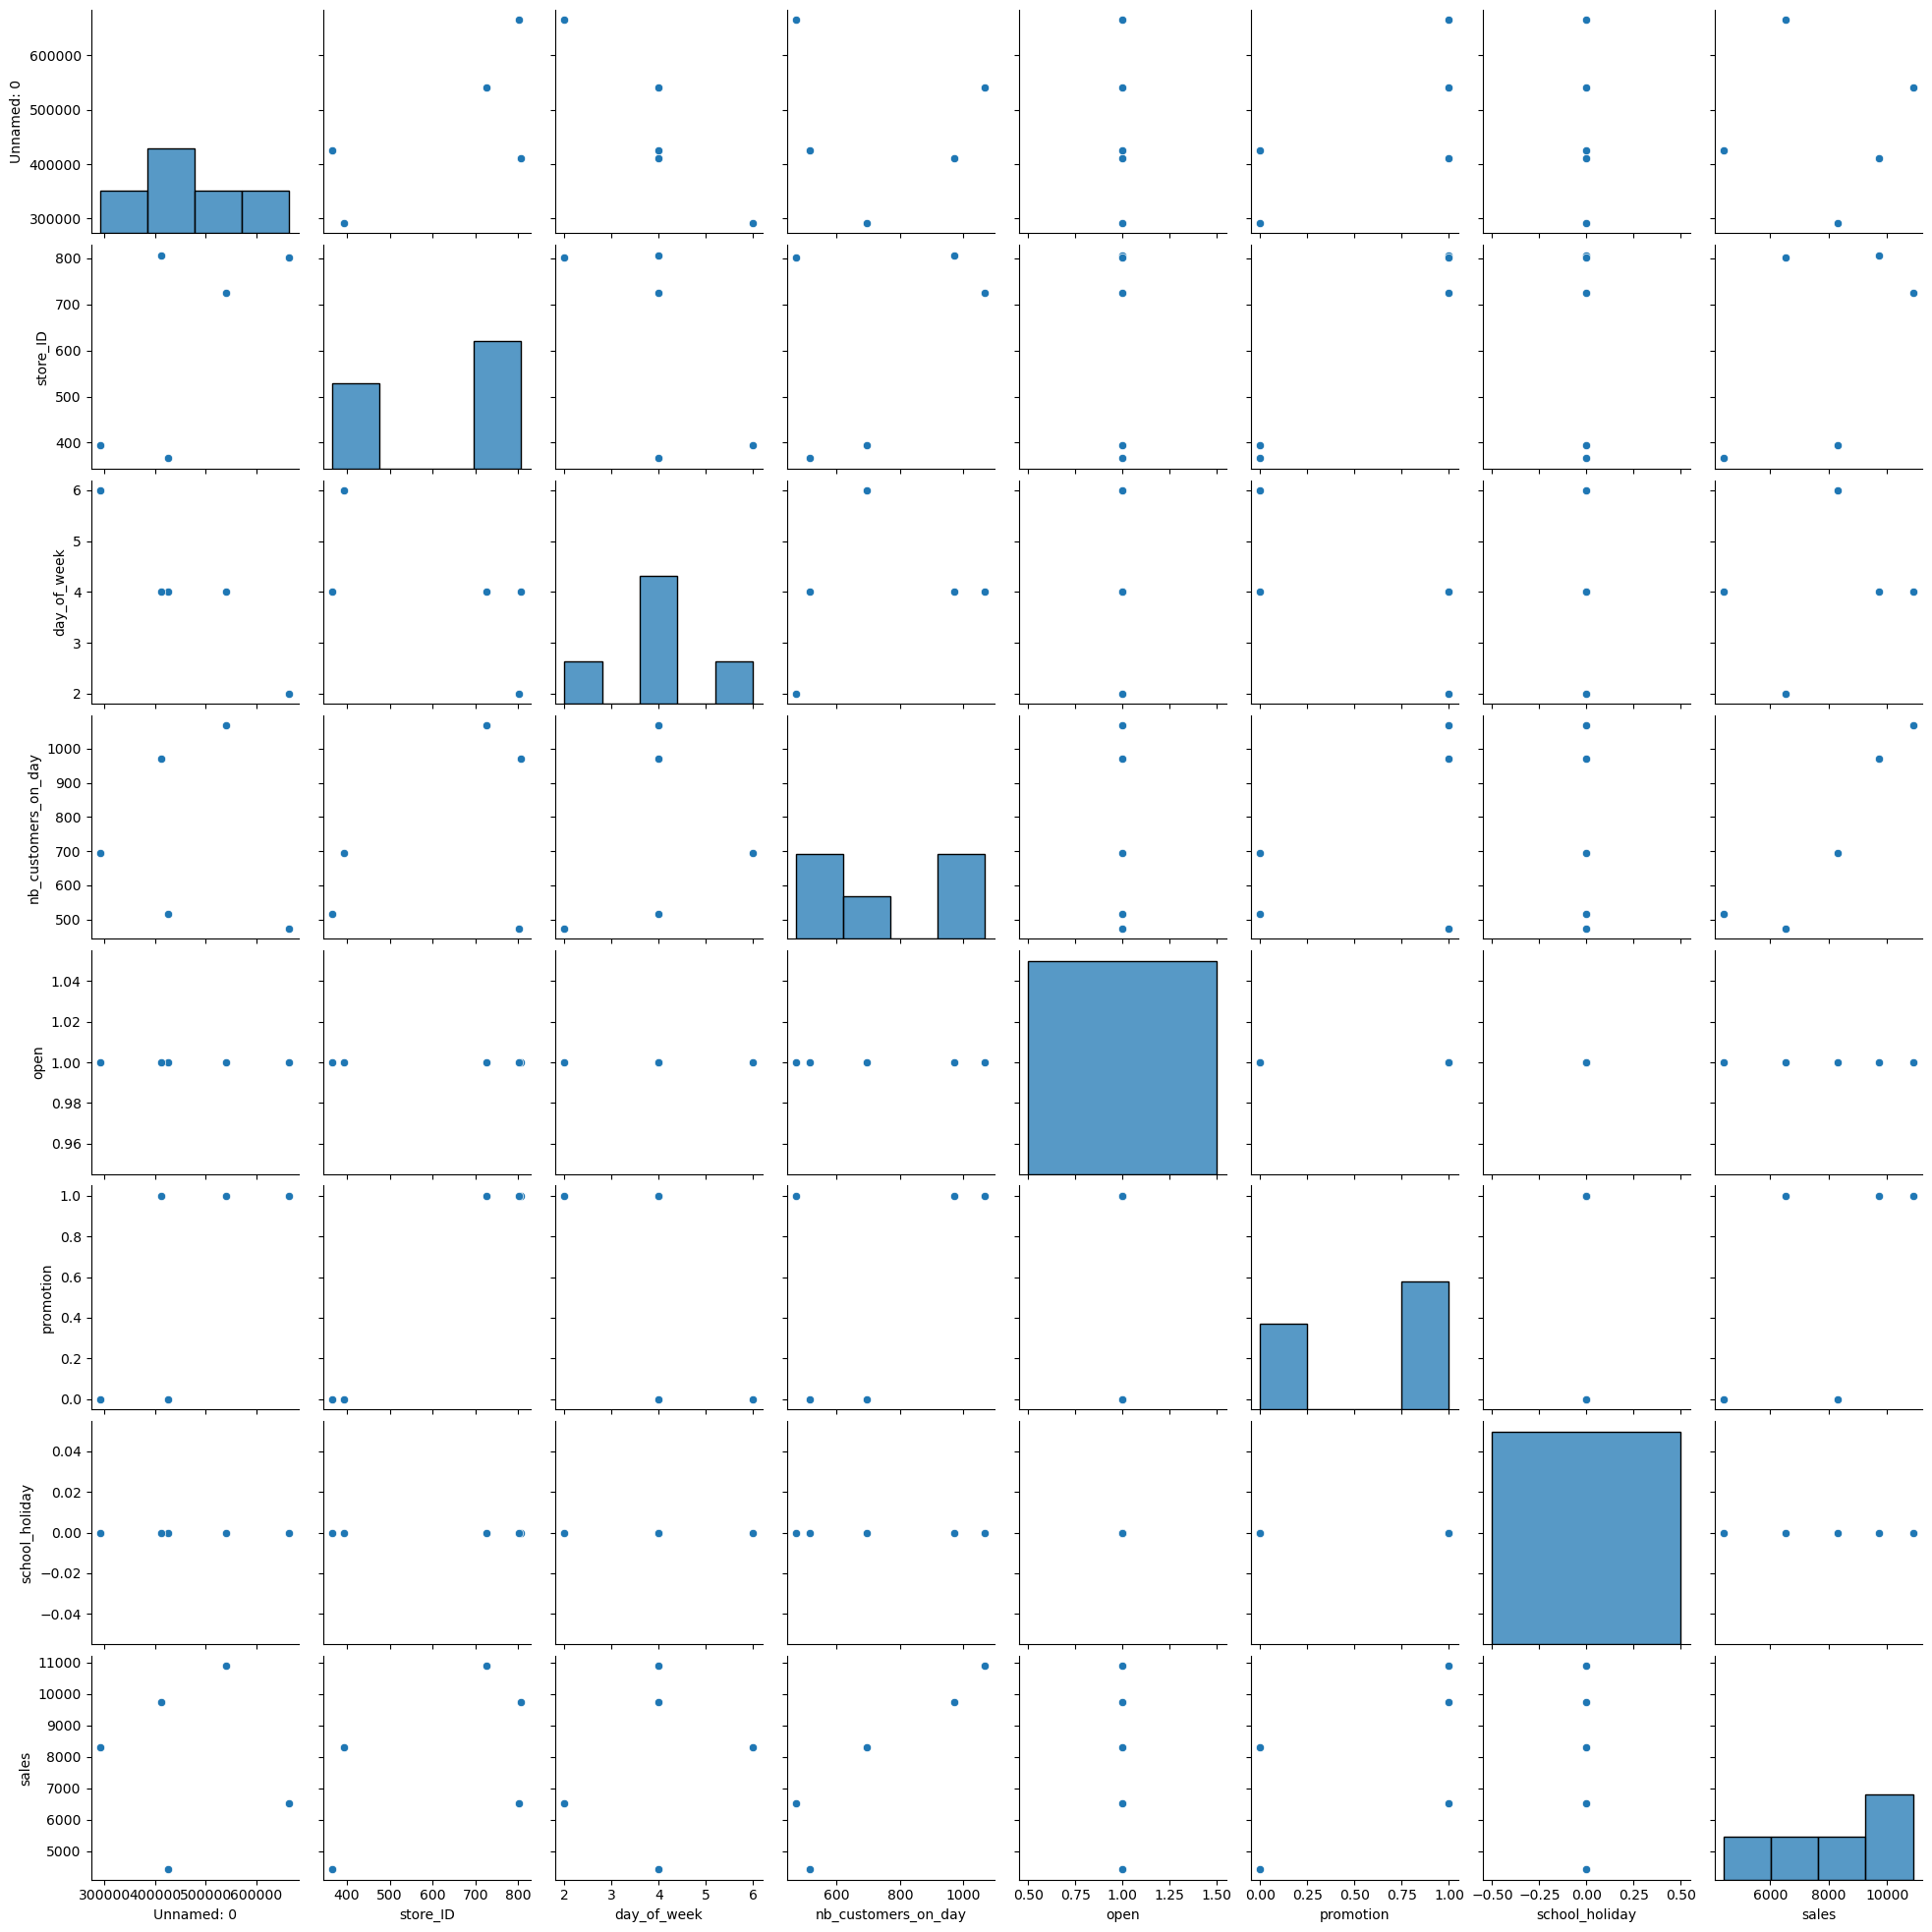

In [3]:
sns.pairplot(df.head())

In [4]:
# Convert 'date' to datetime and extract components

df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df.drop(columns=["date"], inplace=True)

In [5]:
# Encode categorical features
label_encoder = {}
for column in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoder[column] = le

In [6]:
# Splitting the dataset into features (X) and target (y)
X = df.drop(columns=['sales'])
y = df['sales']

In [7]:
# ---- Train Random Forest Model ------------
random_Forest_Model = RandomForestRegressor(
    n_estimators=100,    
    random_state=42,
    n_jobs=-1
) 


In [8]:
# -------- splitting the dataset into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
random_Forest_Model.fit(X_train_full, y_train_full)
y_test_pred = random_Forest_Model.predict(X_test)

In [14]:
#------- cross-validation --------
from sklearn.model_selection import KFold   
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
rmse_scores = []
r2_scores = []

for fold, (train_idx,val_idx) in enumerate(kf.split(X), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    random_Forest_Model.fit(X_train, y_train)
    y_pred = random_Forest_Model.predict(X_val)
    
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)
    # after each fold, we can print the results to compare the performance across 
    # apples and oranges (which helps in choosing the best model)   
    
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    print(f"Fold {fold}: RMSE: {rmse:.2f}, R² Score: {r2:.2f}")
print("Average R² Score:", np.mean(r2_scores))
print("\nAverage RMSE Score:", np.mean(rmse_scores))

Fold 1: RMSE: 903.29, R² Score: 0.94
Fold 2: RMSE: 891.36, R² Score: 0.95
Fold 3: RMSE: 891.40, R² Score: 0.95
Fold 4: RMSE: 898.39, R² Score: 0.95
Fold 5: RMSE: 903.18, R² Score: 0.95
Average R² Score: 0.945688175547617

Average RMSE Score: 897.5248789636147


C:\Users\katyd\AppData\Local\Temp\ipykernel_26448\3005689331.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f'Fold {i+1}' for i in range(len(r2_scores))], y=r2_scores, palette="Blues_d")
C:\Users\katyd\AppData\Local\Temp\ipykernel_26448\3005689331.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f'Fold {i+1}' for i in range(len(rmse_scores))], y=rmse_scores, palette="Oranges_d")


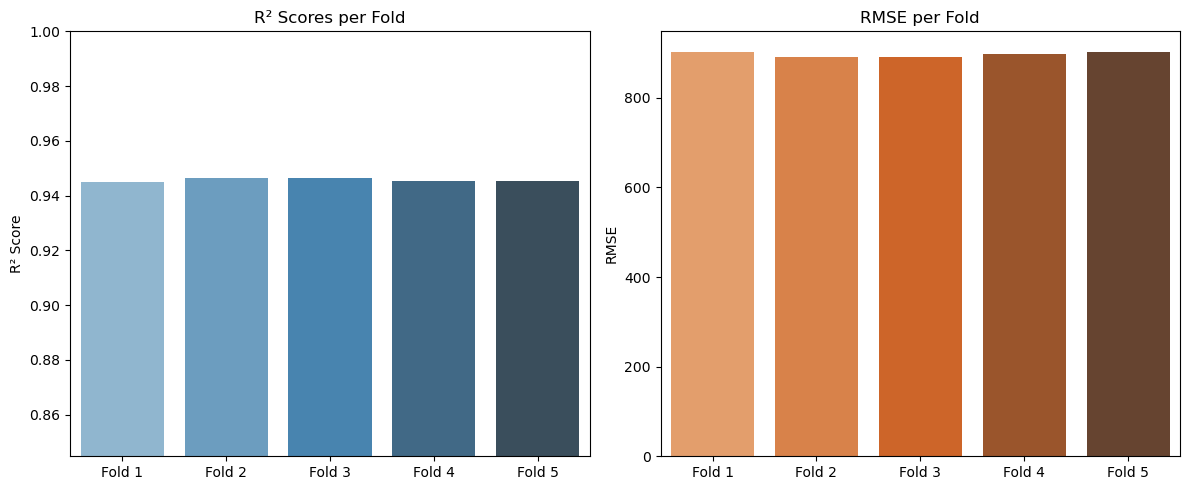

In [15]:
# ---- Plot Cross-Validation Results -----
if r2_scores and rmse_scores:
    plt.figure(figsize=(12, 5))

    # R² bar plot
    plt.subplot(1, 2, 1)
    sns.barplot(x=[f'Fold {i+1}' for i in range(len(r2_scores))], y=r2_scores, palette="Blues_d")
    plt.title("R² Scores per Fold")
    plt.ylim(min(r2_scores) - 0.1, 1)
    plt.ylabel("R² Score")

    # RMSE bar plot
    plt.subplot(1, 2, 2)
    sns.barplot(x=[f'Fold {i+1}' for i in range(len(rmse_scores))], y=rmse_scores, palette="Oranges_d")
    plt.title("RMSE per Fold")
    plt.ylabel("RMSE")

    plt.tight_layout()
    plt.show()
else:
    print("Cross-validation scores not available. Please rerun the model training and validation steps.")




Final Model Evaluation on Test Set:
R² Score: 0.9450
RMSE: 901.8456


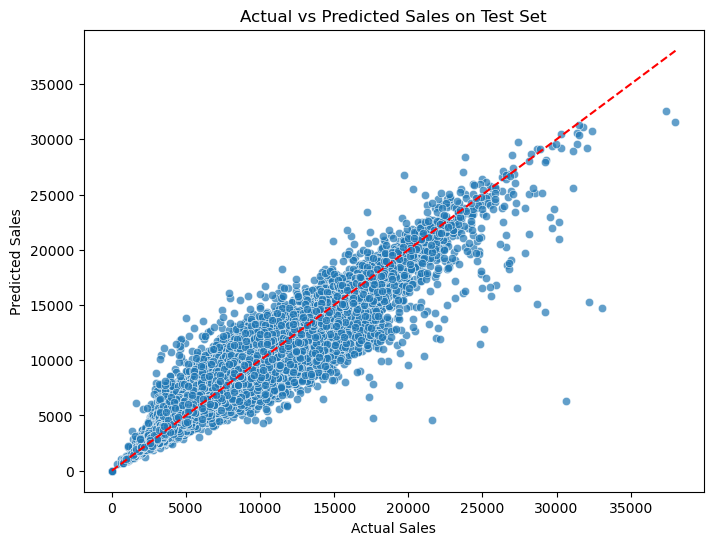

In [16]:
# --- Final Test Set Evaluation ------

final_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
final_r2 = r2_score(y_test, y_test_pred)


print("\nFinal Model Evaluation on Test Set:")
print(f"R² Score: {final_r2:.4f}")
print(f"RMSE: {final_rmse:.4f}")

# Plot actual vs predicted for test set
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales on Test Set")
plt.show()

In [17]:
################# load the real Data #################
# Assuming the real data is in a CSV file named "REAL_DATA.csv"
df_real_data = pd.read_csv('REAL_DATA.csv')
print(" First 5 Rows:\n", df.head())
print("\n Data Shape:", df.shape)
print("\n Missing Values:\n", df.isnull().sum())
df.describe()
df.dtypes

 First 5 Rows:
    Unnamed: 0  store_ID  day_of_week  nb_customers_on_day  open  promotion  \
0      425390       366            4                  517     1          0   
1      291687       394            6                  694     1          0   
2      411278       807            4                  970     1          1   
3      664714       802            2                  473     1          1   
4      540835       726            4                 1068     1          1   

   state_holiday  school_holiday  sales  year  month  day  
0              0               0   4422  2013      4   18  
1              0               0   8297  2015      4   11  
2              0               0   9729  2013      8   29  
3              0               0   6513  2013      5   28  
4              0               0  10882  2013     10   10  

 Data Shape: (640840, 12)

 Missing Values:
 Unnamed: 0             0
store_ID               0
day_of_week            0
nb_customers_on_day    0
open     

Unnamed: 0             int64
store_ID               int64
day_of_week            int64
nb_customers_on_day    int64
open                   int64
promotion              int64
state_holiday          int64
school_holiday         int64
sales                  int64
year                   int32
month                  int32
day                    int32
dtype: object

In [18]:
# Apply same date preprocessing
# Convert 'date' column to datetime format (e.g., from string '01/03/2020' to datetime object)
# 'errors="coerce"' turns invalid or missing dates into NaT (not-a-time), preventing crashes
df_real_data['date'] = pd.to_datetime(df_real_data['date'], errors='coerce')
df_real_data['year'] = df_real_data['date'].dt.year
df_real_data['month'] = df_real_data['date'].dt.month
df_real_data['day'] = df_real_data['date'].dt.day

# Drop the original 'date' column because the model wasn't trained on it directly
df_real_data.drop(columns=['date'], inplace=True)

In [19]:
# Apply same LabelEncoders used in training
# Loop through all object (categorical) columns in real_data
for column in df_real_data.select_dtypes(include='object').columns:
    
    # Check if this column was seen during training and has an encoder    
    if column in label_encoder:
        le = label_encoder[column]
        try:
              # Transform real_data using the same encoder that was fit on training data
            df_real_data[column] = le.transform(df_real_data[column])
        except ValueError as e:
             # If real_data has a category that the model never saw during training, this will catch it
            print(f"Encoding Error in column '{column}': {e}")
            # Optional: add handling like replacing unknowns with most common class
    else:
         # If real_data contains a new column not seen in training — warn the user
        print(f"Warning: Unexpected categorical column '{column}' in real data.")

In [20]:
# Ensure columns match training features
# compare the columns of real_data to the columns used during training
if set(df_real_data.columns)!= set(X.columns):
    print("Warning: Real data does not match training features. Missing or extra columns may cause errors.")

print("Expected columns:", list(X.columns))
print("Real data columns:", list(df_real_data.columns))

Expected columns: ['Unnamed: 0', 'store_ID', 'day_of_week', 'nb_customers_on_day', 'open', 'promotion', 'state_holiday', 'school_holiday', 'year', 'month', 'day']
Real data columns: ['index', 'store_ID', 'day_of_week', 'nb_customers_on_day', 'open', 'promotion', 'state_holiday', 'school_holiday', 'year', 'month', 'day']


In [21]:
missing_columns = set(X.columns) - set(df_real_data.columns)
extra_columns = set(df_real_data.columns) - set(X.columns)
if missing_columns:
    print(f"Warning: Missing columns in real data: {missing_columns}")
if extra_columns:
    print(f"Warning: Extra columns in real data: {extra_columns}")
    


In [22]:
for col in missing_columns:
    df_real_data[col] = 0
    
# drop the extra
df_real_data.drop(columns=list(extra_columns), inplace=True)

In [23]:
df_real_data = df_real_data[X.columns]

In [24]:
df_real_data['sales'] = random_Forest_Model.predict(df_real_data)
print("\nPredicted Sales for Real Data:", df_real_data[['sales']])


Predicted Sales for Real Data:          sales
0         0.00
1         0.00
2      6117.44
3      7825.08
4      5795.15
...        ...
71200     0.00
71201     0.00
71202  5578.56
71203  6579.95
71204  7881.85

[71205 rows x 1 columns]


In [25]:
df_real_data.to_csv('G2.csv', index=False)

In [26]:
df_g2 = pd.read_csv('G2.csv')

In [27]:
df_g2.describe()

,Unnamed: 0,store_ID,day_of_week,nb_customers_on_day,open,promotion,state_holiday,school_holiday,year,month,day,sales
count,71205.0,71205.000000,71205.000000,71205.000000,71205.000000,71205.000000,71205.000000,71205.000000,28387.000000,28387.000000,28387.000000,71205.000000
mean,0.0,559.239857,4.000955,633.412387,0.830068,0.379735,0.044660,0.179187,2013.835312,6.516892,5.846620,5767.668957
std,0.0,322.078792,1.997519,466.753188,0.375576,0.485324,0.281391,0.383511,0.776946,3.452829,3.320808,3686.505904
min,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013.000000,1.000000,1.000000,0.000000
25%,0.0,281.000000,2.000000,403.000000,1.000000,0.000000,0.000000,0.000000,2013.000000,4.000000,3.000000,3960.160000
50%,0.0,557.000000,4.000000,609.000000,1.000000,0.000000,0.000000,0.000000,2014.000000,7.000000,6.000000,5908.100000
75%,0.0,839.000000,6.000000,836.000000,1.000000,1.000000,0.000000,0.000000,2014.000000,10.000000,8.000000,7783.660000
max,0.0,1115.000000,7.000000,5494.000000,1.000000,1.000000,3.000000,1.000000,2015.000000,12.000000,12.000000,35673.090000
